# Simple gender analysis

- ## Imports

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import seaborn as sns

import os, sys, json, re, argparse, urllib2, html5lib
from os import listdir
from os.path import isfile, join
from bs4 import BeautifulSoup, Tag, UnicodeDammit
import pandas as pd
from pandas.io.json import json_normalize
import time
import math
from parse_script import *
from crawler import *

- ## Crawl

- ### Extract functions

In [2]:
path='../data/top100 per year/curated/'
col=['classement','titre','annee','annee_','categorie','realisateur','url','url_script']
titles=pd.DataFrame(columns=col)
for year in range(1995,2017):
    df=get_curated(year,path)
    df['annee_']=year
    titles = pd.concat([titles,df])

In [3]:
#retraiter la colonne catégorie
titles.reset_index(inplace=True,drop=True)
titles['categorie']=titles['categorie'].apply(lambda x : x.replace('\n','').replace(' ',''))
titles['categorie1'], titles['categorie2'], titles['categorie3']= titles['categorie'].str.split(',', 2).str

In [4]:
#consolider le dataframe pour les liens qui ont un lien script
titles = titles.dropna(subset=['url_script'],how='any')
titles.reset_index(inplace=True,drop=True)
titles

,annee,annee_,categorie,classement,duree,realisateur,titre,url,url_script,categorie1,categorie2,categorie3
0,(1995),1995.0,"Animation,Adventure,Comedy",1.0,81 min,John Lasseter,Toy Story,http://www.imsdb.com/Movie Scripts/Toy Story S...,http://www.imsdb.com/scripts/Toy-Story.html,Animation,Adventure,Comedy
1,(I) (1995),1995.0,"Adventure,Drama,History",3.0,140 min,Ron Howard,Apollo 13,http://www.imsdb.com/Movie Scripts/Apollo 13 S...,http://www.imsdb.com/scripts/Apollo-13.html,Adventure,Drama,History
2,(1995),1995.0,"Crime,Drama,Mystery",9.0,127 min,David Fincher,Se7en,http://www.imsdb.com/Movie Scripts/Se7en Scrip...,http://www.imsdb.com/scripts/Se7en.html,Crime,Drama,Mystery
3,(1995),1995.0,"Drama,Music",14.0,143 min,Stephen Herek,Mr. Holland's Opus,http://www.imsdb.com/Movie Scripts/Mr. Holland...,http://www.imsdb.com/scripts/Mr.-Holland's-Opu...,Drama,Music,NaN
4,(1995),1995.0,"Biography,Drama,History",18.0,178 min,Mel Gibson,Braveheart,http://www.imsdb.com/Movie Scripts/Braveheart ...,http://www.imsdb.com/scripts/Braveheart.html,Biography,Drama,History
5,(1995),1995.0,"Comedy,Crime,Thriller",19.0,105 min,Barry Sonnenfeld,Get Shorty,http://www.imsdb.com/Movie Scripts/Get Shorty ...,http://www.imsdb.com/scripts/Get-Shorty.html,Comedy,Crime,Thriller
6,(1995),1995.0,"Action,Crime,Drama",25.0,170 min,Michael Mann,Heat,http://www.imsdb.com/Movie Scripts/Heat Script...,http://www.imsdb.com/scripts/Heat.html,Action,Crime,Drama
7,(1995),1995.0,"Action,Comedy,Crime",28.0,119 min,Michael Bay,Bad Boys,http://www.imsdb.com/Movie Scripts/Bad Boys Sc...,http://www.imsdb.com/scripts/Bad-Boys.html,Action,Comedy,Crime
8,(1995),1995.0,"Comedy,Romance",32.0,97 min,Amy Heckerling,Clueless,http://www.imsdb.com/Movie Scripts/Clueless Sc...,http://www.imsdb.com/scripts/Clueless.html,Comedy,Romance,NaN
9,(1995),1995.0,"Drama,Romance",39.0,136 min,Ang Lee,Sense and Sensibility,http://www.imsdb.com/Movie Scripts/Sense and S...,http://www.imsdb.com/scripts/Sense-and-Sensibi...,Drama,Romance,NaN


In [5]:
a = pd.get_dummies(titles, columns=['categorie1'],drop_first=False)


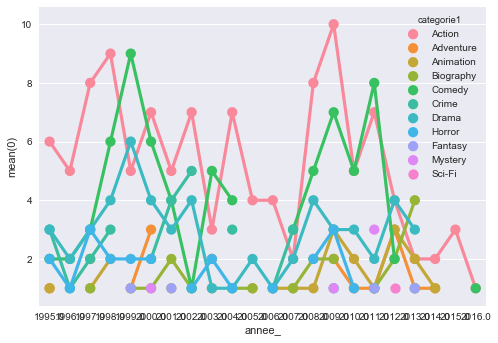

In [6]:
a = pd.get_dummies(titles, columns=['categorie1'],drop_first=False)
a =titles.groupby(['annee_',"categorie1"]).size()
a = a.reset_index()

sns.pointplot(x="annee_", y=0, hue="categorie1", data=a)

In [7]:
print('Only remains %s movies.'%(len(titles)))

Only remains 367 movies.


In [8]:
#les différentes catégories:
l=list(titles.categorie1)+list(titles.categorie2)+list(titles.categorie3)
set(l)

{nan,
 u'Action',
 u'Adventure',
 u'Animation',
 u'Biography',
 u'Comedy',
 u'Crime',
 u'Drama',
 u'Family',
 u'Fantasy',
 u'History',
 u'Horror',
 u'Music',
 u'Musical',
 u'Mystery',
 u'Romance',
 u'Sci-Fi',
 u'Sport',
 u'Thriller',
 u'War',
 u'Western'}

- ### Analysis Functions

In [9]:
def clean_character(char):
    if isinstance(char,unicode) or isinstance(char,str):
        char=char.replace('\n','').replace('*','').replace('O/S','').replace('V.O.','')
        char=re.sub(' +',' ',char)
        if 'CONTINUED' in char:
            return u'CONTINUED'
        if '(' in char or ')' in char:
            regex = re.compile(".*?\((.*?)\)")
            to_delete = re.findall(regex, char)
            for e in to_delete:
                char=char.replace('(%s)' %e,'')
            if char=='' or ')'in char:
                return None
            else:
                return char.rstrip() #delete lose end white space
        else:
            return char.rstrip()
    else:
        return None
    
def continued_speech(char_vector):
    char_vector=list(char_vector)
    while 'CONTINUED' in char_vector:
        count=0
        idx=char_vector.index("CONTINUED")
        for element in char_vector[idx-1::-1]:
            #if (isinstance(element,str) or isinstance(element,unicode)) and (element!='unknown'):
            if element and element!='unknown':
                char_vector[idx]=char_vector[idx-1-count]
                #print('Replaces CONTINUED with %s' %(char_vector[idx-1-count]))
                break
            count=count+1
            if count==len(char_vector[idx-1::-1]):
                char_vector[idx]='unknown'
                break
    return char_vector


# to remove outliers
def principal_characters(char_dic):
    mean = 0
    for i, j in char_dic.items():
        mean = mean + j
    mean = mean / len(char_dic)

    stddev = 0
    for i, j in char_dic.items():
        stddev = stddev + (j - mean)*(j - mean)
    stddev = stddev / len(char_dic)
    stddev = math.sqrt(stddev)

    temp = {}
    for i, j in char_dic.items():
        if (math.fabs(j - mean) < 3*stddev):
            temp[i] = j
    print(stddev,mean)
    return temp


def char_analysis(df):
    d=dict(Counter(df['character_clean']))
    d={key: value for key, value in d.items() 
                 if key}
    charlist = sorted(d)
    gender = dict()
    lines=[element.split('\n') for element in df['text']]
    lines=[item for sublist in lines for item in sublist]

    for char in charlist:
        m, f, p = 0, 0, 0 
        for i in range(len(lines)):
            srch = re.search(char, lines[i], re.I)
            if not srch:
                continue
            if srch.group().isupper():
                continue
            else:
                k, k_range = -1, 2
                while k + i + 1 < len(lines):
                    k = k + 1
                    m = m + len(re.findall("\s+he", lines[k+i], re.I)) + len(re.findall("\s+him", lines[k+i], re.I))
                    f = f + len(re.findall("\s+she", lines[k+i], re.I)) + len(re.findall("\s+her", lines[k+i], re.I))
                    if lines[k+i].isupper():
                        break
                    if k >= k_range:
                        break
                k, k_range = -1, 4
                while k + i + 1 < len(lines):
                    k = k + 1
                    m1, m2, m3, m4 = re.search("\s+he", lines[k+i], re.I), re.search("\s+him", lines[k+i], re.I),\
                                    re.search("\s+she", lines[k+i], re.I), re.search("\s+her", lines[k+i], re.I)
                    if m1:
                        if m2:
                            mc = min(m1.span()[0], m2.span()[0])
                        else:
                            mc = m1.span()[0]
                    else:
                        mc = len(lines[k+i])
                    if m3:
                        if m4:
                            fc = min(m3.span()[0], m4.span()[0])
                        else:
                            fc = m3.span()[0]
                    else:
                        fc = len(lines[k+i])
                    if not(m1 or m2 or m3 or m4):
                        continue
                    else:
                        if (mc < fc):
                            p = p - 1
                        else:
                            p = p + 1
                        break
                    if lines[k+i].isupper():
                        break
                    if k >= k_range:
                        break
        gender[char] = m, f, p

    for char, g in gender.items():
        g_score = 2*g[1] - g[0] 
        g_sum = g[1]+g[0]
        g_score = g_score
        if (g_sum == 0.0) :#or (0 == 1):
            #print(char+" Undetermined ")
            gender[char] = "?" #0, 0, -1
        elif g_score > 0:
            #print(char+" Female "+str(g[0])+","+str(g[1])+","+str(g[2])+","+str(g_score))
            gender[char] = "F" #0, 0, 1
        else:
            #print(char+" Male", " ", str(g[0])+","+str(g[1])+","+str(g[2])+","+str(g_score))
            gender[char] = "M" #0, 0, 0
            
    return d,gender

- ### Script loader and parser

In [10]:
def get_all_bygenre(genre,titles):
    urls = list(titles[(titles['categorie1']==genre) | (titles['categorie2']==genre)]['url_script'])
    output=[]
    nb_of_errors=0
    for url in urls:
        path='../data/script/%s/' %(genre.lower())
        name=url.replace(':','').replace('/','')
        name_ = titles[titles['url_script']==url]['titre']
        name_ = list(name_)[0]
        try:
            test=parse(url,path+'raw/',name_)
            try:
                #print(df['text'][0].split('\n')[0])
                vec=test['character'].apply(lambda x :clean_character(x))
                test['character_clean']=continued_speech(vec)
                char,gender=char_analysis(test)
                #output_actions_.append(char)
                #create gender column in dataframe:
                test['gender']=[gender.get(item,item)  for item in list(test['character_clean'])]
                if not os.path.exists(path+'clean/'):
                    os.makedirs(path+'clean/')
                test.to_csv(path+'clean/'+name_+'.csv',sep='|',encoding='latin1')
            except Exception as e:
                print('------Caught exception : %s' %e)
                nb_of_errors=nb_of_errors+1
            output.append(test)
        except Exception as e:
            print(e)
            nb_of_errors=nb_of_errors+1
    return output

def load_bygenre(genre):
    genre=genre.lower()
    mypath = "../data/script/%s/clean/" %(genre)
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    output=[]
    for element in onlyfiles:
        output.append(pd.read_csv(mypath+element,sep='|',encoding='latin1',index_col=0))
    return output

def number_speech(df):
    m=len(df[df['gender']=='M'])
    f=len(df[df['gender']=='F'])
    return m,f

def nb_char_bygender(df):
    #print(set(df[df['gender']=='M']['character_clean']))
    m=len(set(df[df['gender']=='M']['character_clean']))
    f=len(set(df[df['gender']=='F']['character_clean']))
    return m,f

def plot_piechart(m,f,param,genre):
    #m : list of int
    #f : list of int
    #genre : string of genre
    #param : string of what we want to represent
    m=sum(m)
    f=sum(f)

    labels = ["M","F"]
    sizes = [m, f]
    colors = ['lightskyblue', 'pink']
    plt.figure(figsize=(8,8))
    plt.pie(sizes, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title("Repartition des %s dans les films de %s" %(param,genre)) 
    plt.axis('equal')
    path='../images_bank/charts/'
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig(path + 'Repartition des %s dans les films de %s.png'%(param,genre))
    plt.show()

def create_global_df(list_genre):
    liste = ['genre','nb_of_movies','nb_male','nb_female','nb_male_occurences','nb_female_occurences',
            'nb_prota_male','nb_prota_female']
    df_ = pd.DataFrame(columns=liste)
    for genre in list_genre:
        try:
            dfs = load_bygenre(genre)
            m=[]
            f=[]
            m_nb=[]
            f_nb=[]
            pro_m=[]
            pro_f=[]
            for df in dfs:
                #print(df.head(1))
                try:
                    m.append(number_speech(df)[0])
                    f.append(number_speech(df)[1])
                    m_nb.append(nb_char_bygender(df)[0])
                    f_nb.append(nb_char_bygender(df)[1])
                    pro_m.append(len(set(df[(df['principal_character']==True) & (df['gender']=='M') ]['character_clean'])))
                    pro_f.append(len(set(df[(df['principal_character']==True) & (df['gender']=='F') ]['character_clean'])))
                except Exception as e:
                    print(e)
            x = pd.DataFrame([genre,len(dfs),sum(m_nb),sum(f_nb),sum(m),sum(f),
                             sum(pro_m),sum(pro_f)],index=liste)
            x= x.transpose()
            df_ = df_.append(x,ignore_index=True)
            
        except Exception as e:
            print(e)
    return df_

def find_protagonist(df):
    chars = list(set(df.character_clean))
    for char in chars:
        if len(df[df['character_clean']==char]) > 5:
            df.loc[df['character_clean']==char, 'principal_character'] = True
        else:
            pass
    return df

def update_df_protagonist(genre):
    genre=genre.lower()
    mypath = "../data/script/%s/clean/" %(genre)
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    for element in onlyfiles:
        df = pd.read_csv(mypath+element,sep='|',encoding='latin1',index_col=0)
        if 'protagonist' not in df.columns:
            df = find_protagonist(df)
            df.to_csv(mypath+element,sep='|',encoding='latin1')
        else:
            pass
    print('Done updating local DataFrames for protagonists info for genre %s.' %(genre))
    return

In [11]:
liste=[ u'Action',
 u'Adventure',
 u'Animation',
 u'Biography',
 u'Comedy',
 u'Crime',
 u'Drama',
 u'Family',
 u'Fantasy',
 u'History',
 u'Horror',
 u'Music',
 u'Musical',
 u'Mystery',
 u'Romance',
 u'Sci-Fi',
 u'Sport',
 u'Thriller',
 u'War',
 u'Western']

In [12]:
for element in liste:
    try:
        update_df_protagonist(element)
    except Exception as e:
        print(e)

Done updating local DataFrames for protagonists info for genre action.
Done updating local DataFrames for protagonists info for genre adventure.
Done updating local DataFrames for protagonists info for genre animation.
Done updating local DataFrames for protagonists info for genre biography.
Done updating local DataFrames for protagonists info for genre comedy.
Done updating local DataFrames for protagonists info for genre crime.
Done updating local DataFrames for protagonists info for genre drama.
Done updating local DataFrames for protagonists info for genre family.
Done updating local DataFrames for protagonists info for genre fantasy.
Done updating local DataFrames for protagonists info for genre history.
Done updating local DataFrames for protagonists info for genre horror.
Done updating local DataFrames for protagonists info for genre music.
[Errno 2] No such file or directory: '../data/script/musical/clean/'
Done updating local DataFrames for protagonists info for genre mystery.

In [13]:
global_df =create_global_df(liste)

'principal_character'
'principal_character'
[Errno 2] No such file or directory: '../data/script/musical/clean/'
[Errno 2] No such file or directory: '../data/script/sport/clean/'
[Errno 2] No such file or directory: '../data/script/western/clean/'


In [14]:
global_df

,genre,nb_of_movies,nb_male,nb_female,nb_male_occurences,nb_female_occurences,nb_prota_male,nb_prota_female
0,Action,87,1618,553,41836,14221,833,324
1,Adventure,59,1071,400,31179,10628,567,236
2,Animation,15,213,112,6948,3071,120,65
3,Biography,18,423,168,10013,3884,217,88
4,Comedy,71,991,717,32951,24311,518,405
5,Crime,58,1044,468,29413,11843,556,254
6,Drama,110,1596,1065,46927,36255,800,589
7,Family,1,3,19,61,655,1,11
8,Fantasy,14,220,118,6071,4329,110,74
9,History,4,67,42,1319,1592,38,23


In [15]:
1-float(sum(global_df.nb_prota_male))/(sum(global_df.nb_prota_male)+sum(global_df.nb_prota_female))

0.3778184892897407

/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


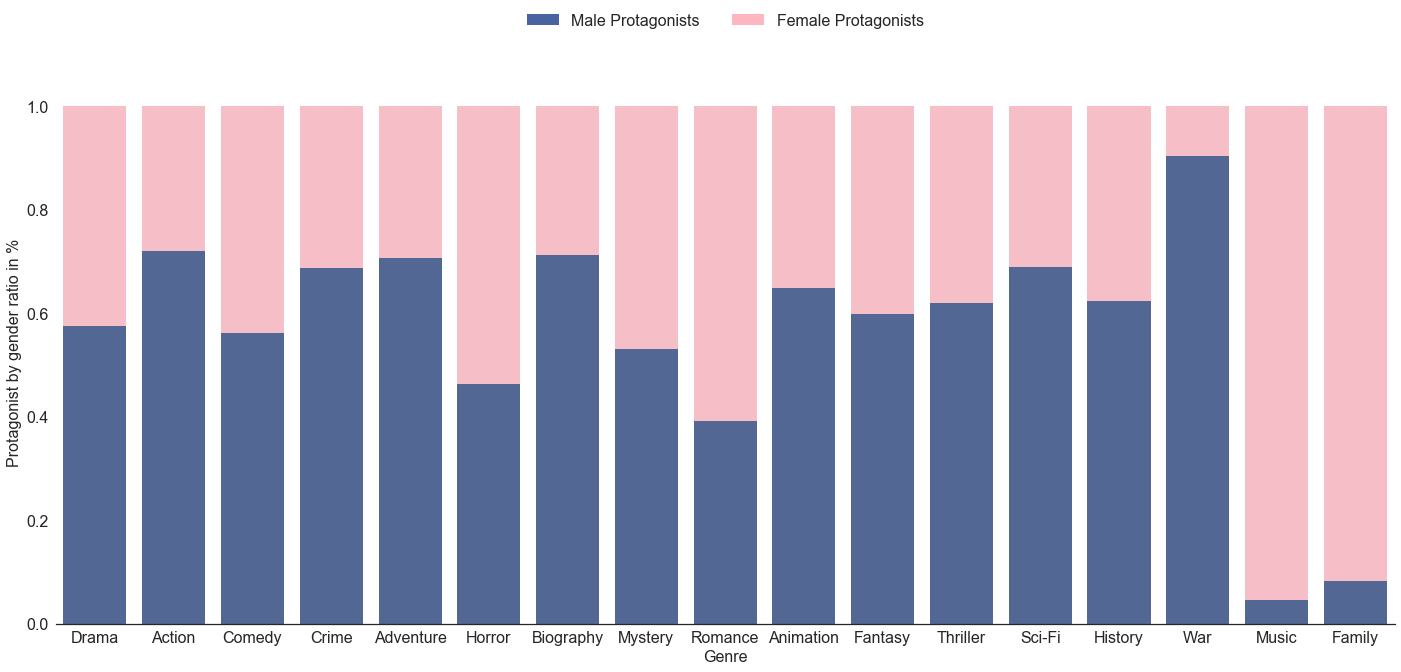

In [16]:
#Read in data & create total column
stacked_bar_data = global_df
stacked_bar_data["total"] = stacked_bar_data.nb_prota_male + stacked_bar_data.nb_prota_female
stacked_bar_data['percentage_f'] = stacked_bar_data.nb_prota_female / stacked_bar_data.total
stacked_bar_data['percentage_m'] = 1- stacked_bar_data.percentage_f
stacked_bar_data['percentage_total']= [1.0]*len(stacked_bar_data)
stacked_bar_data = stacked_bar_data.sort('total',ascending=False)
#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = stacked_bar_data.genre, y = stacked_bar_data.percentage_total, color = "#FFB6C1")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = stacked_bar_data.genre, y = stacked_bar_data.percentage_m, color = "#4863A0")


topbar = plt.Rectangle((0,0),1,1,fc="#FFB6C1", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#4863A0',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Male Protagonists', 'Female Protagonists'], loc='upper center',
                   bbox_to_anchor=(0.5, 1.15), ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Protagonist by gender ratio in %")
bottom_plot.set_xlabel("Genre")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)
plt.savefig('../images_bank/Pourcentage protagoniste H-F par genres de films.png')

/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


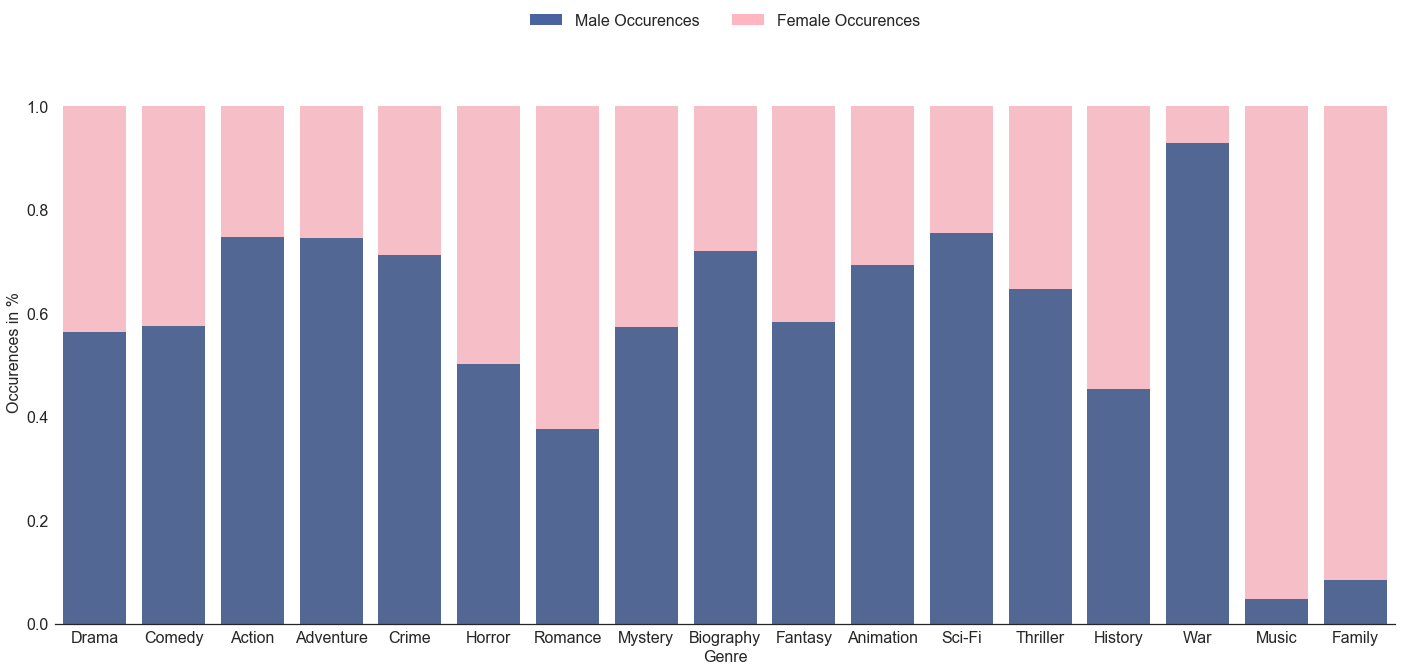

In [17]:
#Read in data & create total column
stacked_bar_data = global_df
stacked_bar_data["total"] = stacked_bar_data.nb_male_occurences + stacked_bar_data.nb_female_occurences
stacked_bar_data['percentage_f'] = stacked_bar_data.nb_female_occurences / stacked_bar_data.total
stacked_bar_data['percentage_m'] = 1- stacked_bar_data.percentage_f
stacked_bar_data['percentage_total']= [1.0]*len(stacked_bar_data)
stacked_bar_data = stacked_bar_data.sort('total',ascending=False)
#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = stacked_bar_data.genre, y = stacked_bar_data.percentage_total, color = "#FFB6C1")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = stacked_bar_data.genre, y = stacked_bar_data.percentage_m, color = "#4863A0")


topbar = plt.Rectangle((0,0),1,1,fc="#FFB6C1", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#4863A0',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Male Occurences', 'Female Occurences'], loc='upper center',
                   bbox_to_anchor=(0.5, 1.15), ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Occurences in %")
bottom_plot.set_xlabel("Genre")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)
plt.savefig('../images_bank/Pourcentage occurences par genres de films.png')

In [18]:
global_df

,genre,nb_of_movies,nb_male,nb_female,nb_male_occurences,nb_female_occurences,nb_prota_male,nb_prota_female,total,percentage_f,percentage_m,percentage_total
0,Action,87,1618,553,41836,14221,833,324,56057,0.253688,0.746312,1.0
1,Adventure,59,1071,400,31179,10628,567,236,41807,0.254216,0.745784,1.0
2,Animation,15,213,112,6948,3071,120,65,10019,0.306518,0.693482,1.0
3,Biography,18,423,168,10013,3884,217,88,13897,0.279485,0.720515,1.0
4,Comedy,71,991,717,32951,24311,518,405,57262,0.424557,0.575443,1.0
5,Crime,58,1044,468,29413,11843,556,254,41256,0.287061,0.712939,1.0
6,Drama,110,1596,1065,46927,36255,800,589,83182,0.435852,0.564148,1.0
7,Family,1,3,19,61,655,1,11,716,0.914804,0.0851955,1.0
8,Fantasy,14,220,118,6071,4329,110,74,10400,0.41625,0.58375,1.0
9,History,4,67,42,1319,1592,38,23,2911,0.546891,0.453109,1.0


In [19]:
global_df[(global_df['genre']=='Action') | (global_df['genre']=='Thriller') |(global_df['genre']=='Crime') |
          (global_df['genre']=='Horror') | (global_df['genre']=='War')  ]

,genre,nb_of_movies,nb_male,nb_female,nb_male_occurences,nb_female_occurences,nb_prota_male,nb_prota_female,total,percentage_f,percentage_m,percentage_total
0,Action,87,1618,553,41836,14221,833,324,56057,0.253688,0.746312,1.0
5,Crime,58,1044,468,29413,11843,556,254,41256,0.287061,0.712939,1.0
10,Horror,28,261,309,8947,8903,158,183,17850,0.498768,0.501232,1.0
15,Thriller,13,194,125,6026,3285,106,65,9311,0.352809,0.647191,1.0
16,War,2,62,8,1428,109,28,3,1537,0.0709174,0.929083,1.0


/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/index

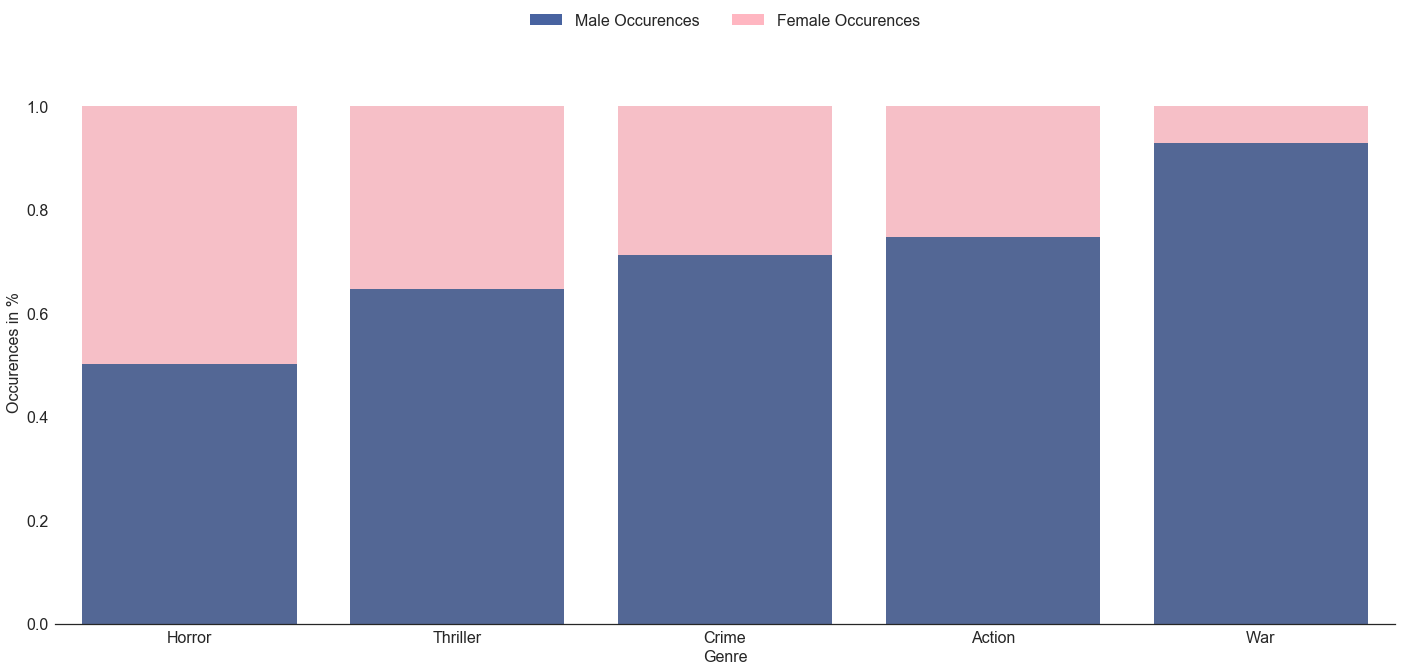

In [20]:
#Read in data & create total column
stacked_bar_data = global_df[(global_df['genre']=='Action') | (global_df['genre']=='Thriller') |
                             (global_df['genre']=='Crime') |(global_df['genre']=='Horror') | (global_df['genre']=='War')  ]
stacked_bar_data["total"] = stacked_bar_data.nb_male_occurences + stacked_bar_data.nb_female_occurences
stacked_bar_data['percentage_f'] = stacked_bar_data.nb_female_occurences / stacked_bar_data.total
stacked_bar_data['percentage_m'] = 1- stacked_bar_data.percentage_f
stacked_bar_data['percentage_total']= [1.0]*len(stacked_bar_data)
stacked_bar_data = stacked_bar_data.sort('percentage_f',ascending=False)
#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = stacked_bar_data.genre, y = stacked_bar_data.percentage_total, color = "#FFB6C1")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = stacked_bar_data.genre, y = stacked_bar_data.percentage_m, color = "#4863A0")


topbar = plt.Rectangle((0,0),1,1,fc="#FFB6C1", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#4863A0',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Male Occurences', 'Female Occurences'], loc='upper center',
                   bbox_to_anchor=(0.5, 1.15), ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Occurences in %")
bottom_plot.set_xlabel("Genre")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)
plt.savefig('../images_bank/Pourcentage occurences par genres de filmsà caractere actions.png')

/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/index

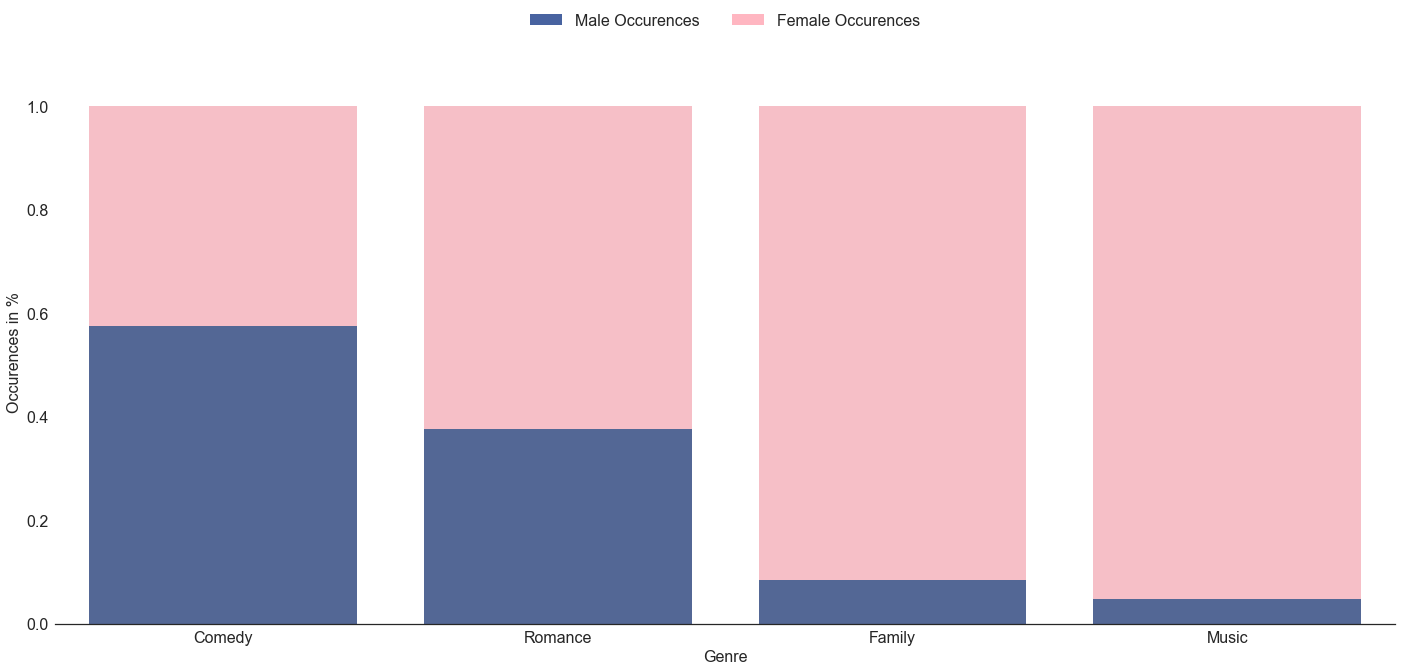

In [21]:
#Read in data & create total column
stacked_bar_data = global_df[(global_df['genre']=='Romance') | (global_df['genre']=='Music') |
                             (global_df['genre']=='Comedy') |(global_df['genre']=='Family')]
stacked_bar_data["total"] = stacked_bar_data.nb_male_occurences + stacked_bar_data.nb_female_occurences
stacked_bar_data['percentage_f'] = stacked_bar_data.nb_female_occurences / stacked_bar_data.total
stacked_bar_data['percentage_m'] = 1- stacked_bar_data.percentage_f
stacked_bar_data['percentage_total']= [1.0]*len(stacked_bar_data)
stacked_bar_data = stacked_bar_data.sort('percentage_m',ascending=False)
#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = stacked_bar_data.genre, y = stacked_bar_data.percentage_total, color = "#FFB6C1")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = stacked_bar_data.genre, y = stacked_bar_data.percentage_m, color = "#4863A0")


topbar = plt.Rectangle((0,0),1,1,fc="#FFB6C1", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#4863A0',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Male Occurences', 'Female Occurences'], loc='upper center',
                   bbox_to_anchor=(0.5, 1.15), ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Occurences in %")
bottom_plot.set_xlabel("Genre")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)
plt.savefig('../images_bank/Pourcentage occurences par genres de films à caractere romantique(?).png')

/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


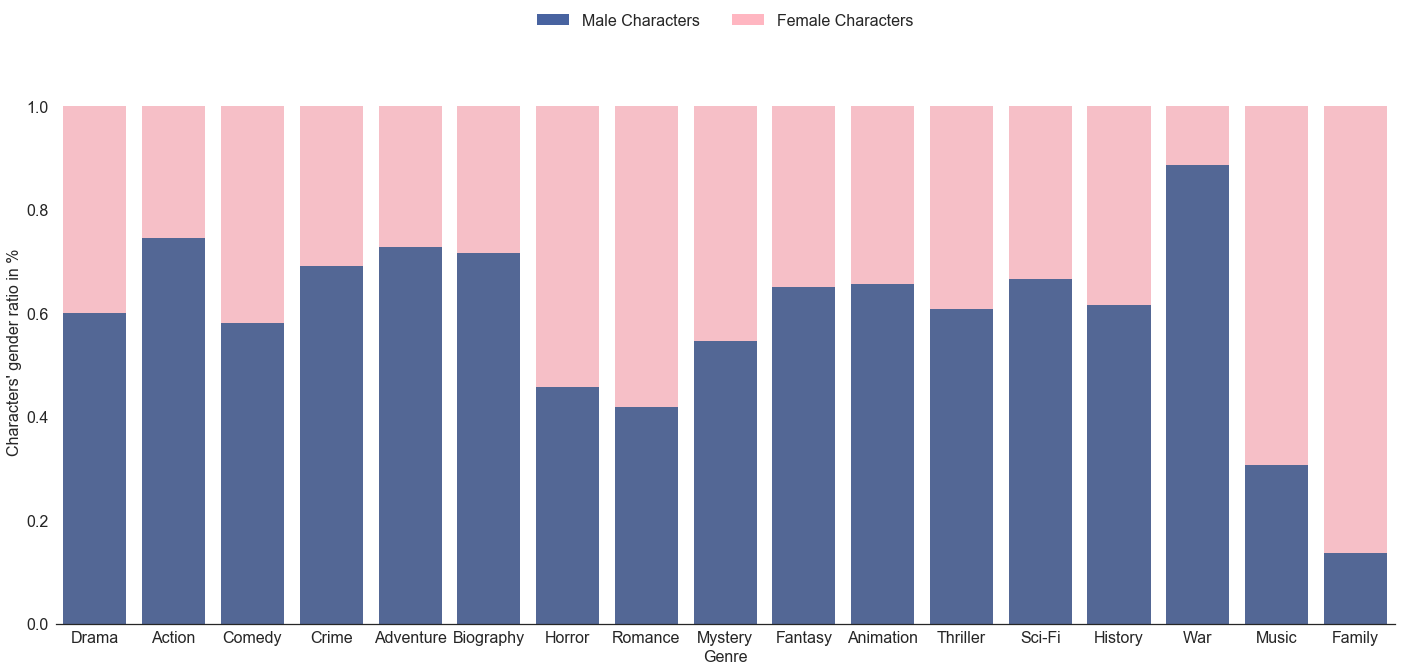

In [22]:
#Read in data & create total column
stacked_bar_data = global_df
stacked_bar_data["total"] = stacked_bar_data.nb_male + stacked_bar_data.nb_female
stacked_bar_data['percentage_f'] = stacked_bar_data.nb_female / stacked_bar_data.total
stacked_bar_data['percentage_m'] = 1- stacked_bar_data.percentage_f
stacked_bar_data['percentage_total']= [1.0]*len(stacked_bar_data)
stacked_bar_data = stacked_bar_data.sort('total',ascending=False)
#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = stacked_bar_data.genre, y = stacked_bar_data.percentage_total, color = "#FFB6C1")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = stacked_bar_data.genre, y = stacked_bar_data.percentage_m, color = "#4863A0")


topbar = plt.Rectangle((0,0),1,1,fc="#FFB6C1", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#4863A0',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Male Characters', 'Female Characters'], loc='upper center',
                   bbox_to_anchor=(0.5, 1.15), ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Characters' gender ratio in %")
bottom_plot.set_xlabel("Genre")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)
plt.savefig('../images_bank/Pourcentage personnages H-F par genres de films.png')

In [23]:
#plot year evolution

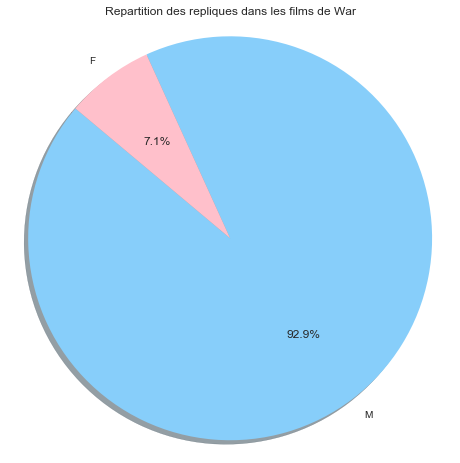

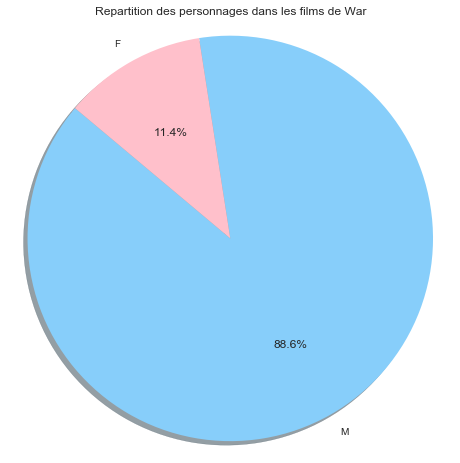

In [24]:
genre='War'
dfs = load_bygenre(genre)
m=[]
f=[]
m_nb=[]
f_nb=[]
for df in dfs:
    #print(df.head(1))
    m.append(number_speech(df)[0])
    f.append(number_speech(df)[1])
    m_nb.append(nb_char_bygender(df)[0])
    f_nb.append(nb_char_bygender(df)[1])

plot_piechart(m,f,'repliques',genre)
plot_piechart(m_nb,f_nb,"personnages",genre)

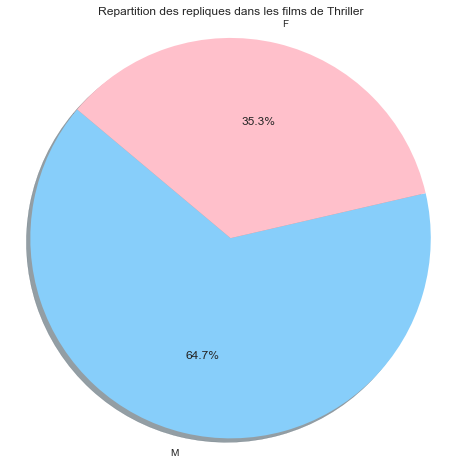

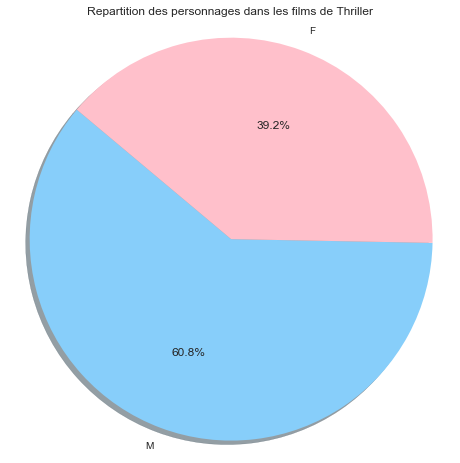

In [25]:
genre='Thriller'
dfs = load_bygenre(genre)
m=[]
f=[]
m_nb=[]
f_nb=[]
for df in dfs:
    #print(df.head(1))
    m.append(number_speech(df)[0])
    f.append(number_speech(df)[1])
    m_nb.append(nb_char_bygender(df)[0])
    f_nb.append(nb_char_bygender(df)[1])

plot_piechart(m,f,'repliques',genre)
plot_piechart(m_nb,f_nb,"personnages",genre)

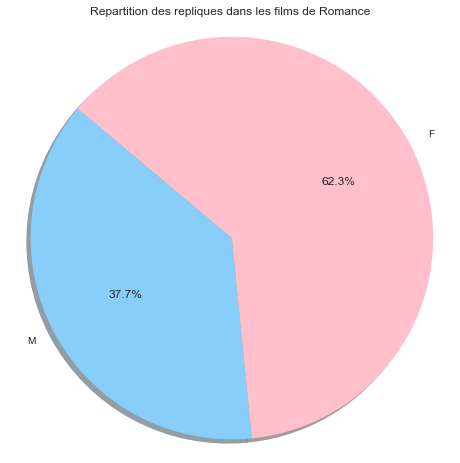

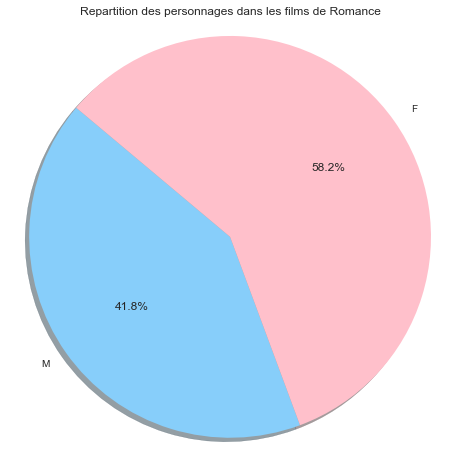

In [26]:
genre='Romance'
dfs = load_bygenre(genre)
m=[]
f=[]
m_nb=[]
f_nb=[]
for df in dfs:
    m.append(number_speech(df)[0])
    f.append(number_speech(df)[1])
    m_nb.append(nb_char_bygender(df)[0])
    f_nb.append(nb_char_bygender(df)[1])

plot_piechart(m,f,'repliques',genre)
plot_piechart(m_nb,f_nb,"personnages",genre)

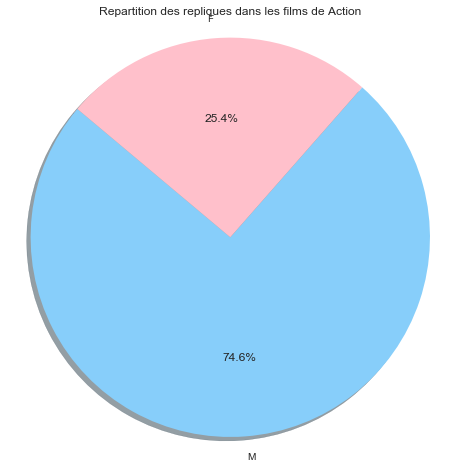

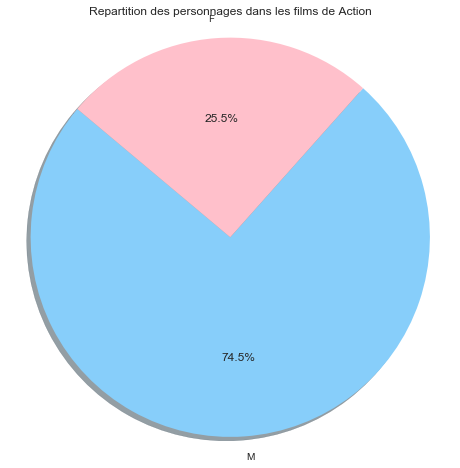

In [27]:
genre='Action'
dfs = load_bygenre(genre)
m=[]
f=[]
m_nb=[]
f_nb=[]
for df in dfs:
    #print(df.head(1))
    m.append(number_speech(df)[0])
    f.append(number_speech(df)[1])
    m_nb.append(nb_char_bygender(df)[0])
    f_nb.append(nb_char_bygender(df)[1])

plot_piechart(m,f,'repliques',genre)
plot_piechart(m_nb,f_nb,"personnages",genre)

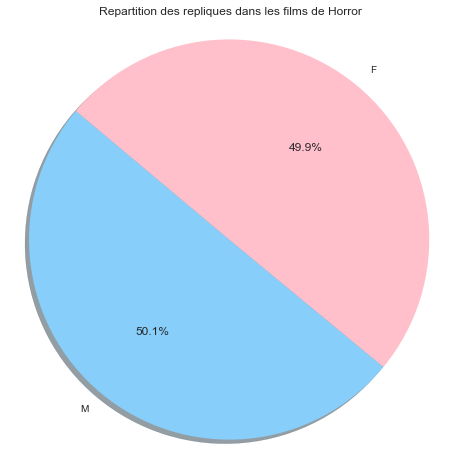

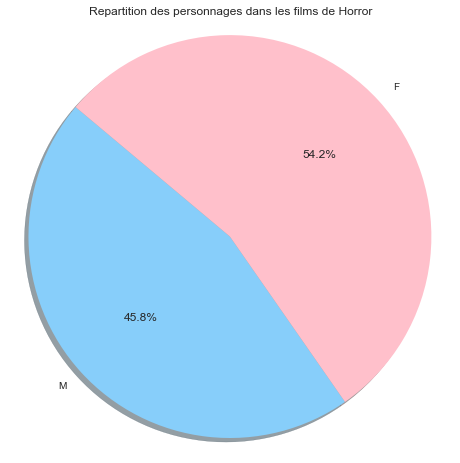

In [28]:
genre='Horror'
dfs = load_bygenre(genre)
m=[]
f=[]
m_nb=[]
f_nb=[]
for df in dfs:
    #print(df.head(1))
    m.append(number_speech(df)[0])
    f.append(number_speech(df)[1])
    m_nb.append(nb_char_bygender(df)[0])
    f_nb.append(nb_char_bygender(df)[1])

plot_piechart(m,f,'repliques',genre)
plot_piechart(m_nb,f_nb,"personnages",genre)

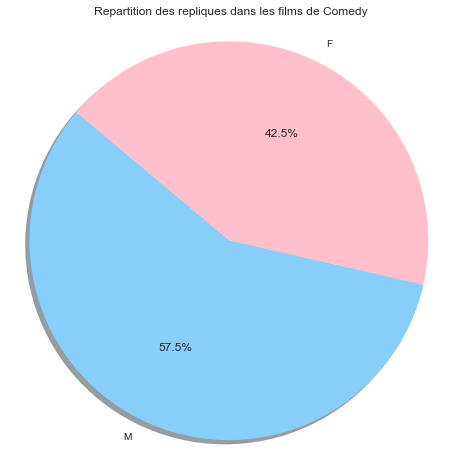

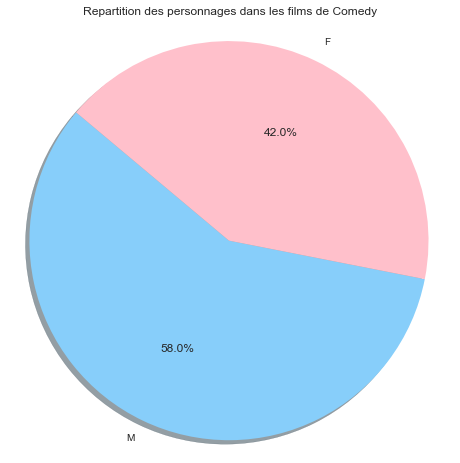

In [29]:
genre='Comedy'
dfs = load_bygenre(genre)
m=[]
f=[]
m_nb=[]
f_nb=[]
for df in dfs:
    #print(df.head(1))
    m.append(number_speech(df)[0])
    f.append(number_speech(df)[1])
    m_nb.append(nb_char_bygender(df)[0])
    f_nb.append(nb_char_bygender(df)[1])

plot_piechart(m,f,'repliques',genre)
plot_piechart(m_nb,f_nb,"personnages",genre)

In [30]:
def create_story_df(list_genre):
    liste = ['genre','nb_of_movies','nb_male','nb_female','nb_total_iloveu','nb_male_iloveu','nb_female_iloveu',
            'nb_male_naked','nb_female_naked','nb_male_garage','nb_female_garage']
    df_ = pd.DataFrame(columns=liste)
    for genre in list_genre:
        try:
            dfs = load_bygenre(genre)
            m=[]
            f=[]
            m_nb=[]
            f_nb=[]
            nb_love=[]
            nb_naked_m=[]
            nb_naked_f=[]
            nb_kitchen_m=[]
            nb_kitchen_f=[]
            for df in dfs:
                #print(df.head(1))
                nb_kitchen_m.append(find_male_in(df,'garage')[0]+find_male_in(df,'workshop')[0])
                nb_kitchen_f.append(find_female_in(df,'garage')[0]+find_female_in(df,'workshop')[0])
                nb_naked_m.append(find_male_in(df,'naked')[0]+find_male_in(df,'nude')[0])
                nb_naked_f.append(find_female_in(df,'naked')[0]+find_female_in(df,'nude')[0])
                nb_love.append(find(df,'love you'))
                m.append(find_male_in(df,'love you')[0])
                f.append(find_female_in(df,'love you')[0])
                m_nb.append(nb_char_bygender(df)[0])
                f_nb.append(nb_char_bygender(df)[1])
            x = pd.DataFrame([genre,len(dfs),sum(m_nb),sum(f_nb),sum(nb_love),sum(m),sum(f),
                             sum(nb_naked_m),sum(nb_naked_f),sum(nb_kitchen_m),sum(nb_kitchen_f)],index=liste)
            x= x.transpose()
            df_ = df_.append(x,ignore_index=True)
            
        except Exception as e:
            print(e)
    return df_

def find(df,to_find):
    count=0
    for element in df['text']:
        if to_find in normalize_text(element):
            count+=1
    return count

def find_female_in(df,to_find):
    count_female=0
    count_total=0
    idx=0
    try:
        list_female=list(df[df['gender']=='F']['character_clean'].apply(lambda x : normalize_text(x)))
        list_female=list(set(list_female))
        #list_female.append('she').append('her')
    except Exception as e:
        try:
            
            for element in df['text']:
                if to_find in normalize_text(element):
                    count_total+=1
                    if 'she' in element or "her" in element:
                        count_female+=1
            return count_female,count_total
        except Exception as ex:
            print('Warning : %s.' %(ex))
            return 0,0
    #list_female.append('she')
    list_female.append("her")
    for element in df['text']:
        if to_find in normalize_text(element):
            count_total+=1
            for indicator in list_female: #she or her
                if indicator in element:
                    count_female+=1
                    break
        idx+=1
    return count_female,count_total

def find_male_in(df,to_find):
    count_female=0
    count_total=0
    idx=0
    try:
        list_female=list(df[df['gender']=='M']['character_clean'].apply(lambda x : normalize_text(x)))
        list_female=list(set(list_female))
        #list_female.append('she').append('her')
    except Exception as e:
        try:
            
            for element in df['text']:
                if to_find in normalize_text(element):
                    count_total+=1
                    if 'he' in element or "him" in element:
                        count_female+=1
            return count_female,count_total
        except Exception as ex:
            print('Warning : %s.' %(ex))
            return 0,0
    list_female.append('him')
    #list_female.append("he ")
    for element in df['text']:
        if to_find in normalize_text(element):
            count_total+=1
            for indicator in list_female: #she or her
                if indicator in element:
                    count_female+=1
                    break
        idx+=1
    return count_female,count_total

def find_any(df,l):
    for element in df['text']:
        for room in l:
            if room in normalize_text(element):
                print("Found %s" %room)
    return

def normalize_text(text):
    text = text.lower()
    normal = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore')
    return normal

In [31]:
data = pd.read_csv('../data/final_dataframe.csv',sep=';',encoding='latin1', index_col=0)

In [32]:
data

,genre,nb_of_movies,nb_male,nb_female,nb_male_occurences,nb_female_occurences,nb_prota_male,nb_prota_female,nb_words_total_male,nb_words_total_female,nb_words_avg_male_per_movie,nb_words_avg_female_per_movie,nb_words_total_prota_male,nb_words_total_prota_female,nb_male_kitchen,nb_female_kitchen
0,Action,87,1618,553,41836,14221,833,324,513555,181441,11,11,490883,174541,225,67
1,Adventure,59,1071,400,31179,10628,567,236,371958,124693,11,10,358620,120293,136,35
2,Animation,15,213,112,6948,3071,120,65,72369,28097,10,8,70384,27285,44,20
3,Biography,18,423,168,10013,3884,217,88,130724,42305,11,10,124138,40781,87,28
4,Comedy,71,991,717,32951,24311,518,405,367610,268878,10,10,356261,261495,360,108
5,Crime,58,1044,468,29413,11843,556,254,350210,124295,11,9,337660,118819,280,97
6,Drama,110,1596,1065,46927,36255,800,589,578336,416929,11,10,554591,403481,667,248
7,Family,1,3,19,61,655,1,11,477,4466,7,6,450,4356,11,10
8,Fantasy,14,220,118,6071,4329,110,74,71683,50521,11,10,66968,49155,33,12
9,History,4,67,42,1319,1592,38,23,20455,21552,13,10,19826,20905,36,23


In [33]:
l=['KITCHEN','Kitchen','kitchen','bed','BED','BEDROOM','Bed','Bedroom','bedroom','BATH','bath','Bath','BATHROOM',
  'Bathroom','bathroom','toilet','TOILET','Toilet']
l_norm=['kitchen','bed','bedroom','bath','bathroom','toilet']

In [34]:
create_story_df(liste)

[Errno 2] No such file or directory: '../data/script/musical/clean/'
[Errno 2] No such file or directory: '../data/script/sport/clean/'
[Errno 2] No such file or directory: '../data/script/western/clean/'


,genre,nb_of_movies,nb_male,nb_female,nb_total_iloveu,nb_male_iloveu,nb_female_iloveu,nb_male_naked,nb_female_naked,nb_male_garage,nb_female_garage
0,Action,87,1618,553,89,10,19,55,73,47,43
1,Adventure,59,1071,400,78,9,15,30,38,27,15
2,Animation,15,213,112,18,2,4,4,2,10,0
3,Biography,18,423,168,30,7,9,3,7,9,9
4,Comedy,71,991,717,202,15,46,31,78,38,29
5,Crime,58,1044,468,90,6,19,43,57,40,53
6,Drama,110,1596,1065,256,20,71,61,125,44,72
7,Family,1,3,19,2,0,0,0,0,0,0
8,Fantasy,14,220,118,43,3,7,5,13,5,3
9,History,4,67,42,3,0,1,1,4,1,0


In [35]:
data_ = create_story_df(liste)
data_.to_csv('../data/final_dataframe3.csv',sep=';',encoding='latin1')

[Errno 2] No such file or directory: '../data/script/musical/clean/'
[Errno 2] No such file or directory: '../data/script/sport/clean/'
[Errno 2] No such file or directory: '../data/script/western/clean/'


In [36]:
data_

,genre,nb_of_movies,nb_male,nb_female,nb_total_iloveu,nb_male_iloveu,nb_female_iloveu,nb_male_naked,nb_female_naked,nb_male_garage,nb_female_garage
0,Action,87,1618,553,89,10,19,55,73,47,43
1,Adventure,59,1071,400,78,9,15,30,38,27,15
2,Animation,15,213,112,18,2,4,4,2,10,0
3,Biography,18,423,168,30,7,9,3,7,9,9
4,Comedy,71,991,717,202,15,46,31,78,38,29
5,Crime,58,1044,468,90,6,19,43,57,40,53
6,Drama,110,1596,1065,256,20,71,61,125,44,72
7,Family,1,3,19,2,0,0,0,0,0,0
8,Fantasy,14,220,118,43,3,7,5,13,5,3
9,History,4,67,42,3,0,1,1,4,1,0


In [47]:
#ratage de ....
def create_story_df(list_genre):
    liste = ['genre','nb_of_movies','nb_male','nb_female','nb_total_iloveu','nb_male_iloveu','nb_female_iloveu',
            'nb_male_help','nb_female_help']
    df_ = pd.DataFrame(columns=liste)
    for genre in list_genre:
        try:
            dfs = load_bygenre(genre)
            m=[]
            f=[]
            m_nb=[]
            f_nb=[]
            nb_love=[]
            nb_naked_m=[]
            nb_naked_f=[]
            for df in dfs:
                #print(df.head(1))
                nb_naked_m.append(pronounced_by(df,'help me','M'))
                nb_naked_f.append(pronounced_by(df,'help me','F'))
                nb_love.append(find(df,'love you'))
                #m.append(find_male_in(df,'love you')[0])
                #f.append(find_female_in(df,'love you')[0])
                m.append(pronounced_by(df,'love you','M'))
                f.append(pronounced_by(df,'love you','F'))
                m_nb.append(nb_char_bygender(df)[0])
                f_nb.append(nb_char_bygender(df)[1])
            x = pd.DataFrame([genre,len(dfs),sum(m_nb),sum(f_nb),sum(nb_love),sum(m),sum(f),
                             sum(nb_naked_m),sum(nb_naked_f)],index=liste)
            x= x.transpose()
            df_ = df_.append(x,ignore_index=True)
            
        except Exception as e:
            print(e)
    return df_

def find(df,to_find):
    count=0
    for element in df['text']:
        if to_find in normalize_text(element):
            count+=1
    return count


def pronounced_by(df,to_find,gender):
    if gender == 'M':
        df = df[df['gender']=='M']
        count=0
        for element in df['text']:
            if to_find in normalize_text(element):
                count=count+1
        return count
    if gender == 'F':
        df = df[df['gender']=='F']
        count=0
        for element in df['text']:
            if to_find in normalize_text(element):
                count=count+1
        return count

def find_female_in(df,to_find):
    count_female=0
    count_total=0
    idx=0
    try:
        list_female=list(df[df['gender']=='F']['character_clean'].apply(lambda x : normalize_text(x)))
        list_female=list(set(list_female))
        #list_female.append('she').append('her')
    except Exception as e:
        try:
            
            for element in df['text']:
                elements = element.split('.')
                for e in elements:
                    if to_find in normalize_text(e):
                        count_total+=1
                        if 'she' in e or "her" in e:
                            count_female+=1
            return count_female,count_total
        except Exception as ex:
            print('Warning : %s.' %(ex))
            return 0,0
    #list_female.append('she')
    list_female.append("her")
    for element in df['text']:
        elements = element.split('.')
        for e in elements:
            if to_find in normalize_text(element):
                count_total+=1
                for indicator in list_female: #she or her
                    if indicator in element:
                        count_female+=1
                        break
        idx+=1
    return count_female,count_total

def find_male_in(df,to_find):
    count_female=0
    count_total=0
    idx=0
    try:
        list_female=list(df[df['gender']=='M']['character_clean'].apply(lambda x : normalize_text(x)))
        list_female=list(set(list_female))
        #list_female.append('she').append('her')
    except Exception as e:
        try:
            
            for element in df['text']:
                if to_find in normalize_text(element):
                    count_total+=1
                    if 'he' in element or "him" in element:
                        count_female+=1
            return count_female,count_total
        except Exception as ex:
            print('Warning : %s.' %(ex))
            return 0,0
    list_female.append('him')
    #list_female.append("he ")
    for element in df['text']:
        if to_find in normalize_text(element):
            count_total+=1
            for indicator in list_female: #she or her
                if indicator in element:
                    count_female+=1
                    break
        idx+=1
    return count_female,count_total

def find_any(df,l):
    for element in df['text']:
        for room in l:
            if room in normalize_text(element):
                print("Found %s" %room)
    return

def normalize_text(text):
    text = text.lower()
    normal = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore')
    return normal

In [48]:
create_story_df(liste)

[Errno 2] No such file or directory: '../data/script/musical/clean/'
[Errno 2] No such file or directory: '../data/script/sport/clean/'
[Errno 2] No such file or directory: '../data/script/western/clean/'


,genre,nb_of_movies,nb_male,nb_female,nb_total_iloveu,nb_male_iloveu,nb_female_iloveu,nb_male_help,nb_female_help
0,Action,87,1618,553,89,36,38,75,31
1,Adventure,59,1071,400,78,44,25,60,18
2,Animation,15,213,112,18,7,8,11,6
3,Biography,18,423,168,30,13,7,9,7
4,Comedy,71,991,717,202,72,80,45,30
5,Crime,58,1044,468,90,34,32,37,17
6,Drama,110,1596,1065,256,86,90,63,51
7,Family,1,3,19,2,0,2,0,1
8,Fantasy,14,220,118,43,21,18,5,14
9,History,4,67,42,3,0,2,0,2


In [44]:
df = create_story_df(liste)
df.to_csv('../data/final_dataframe4.csv',sep=';',encoding='latin1')

[Errno 2] No such file or directory: '../data/script/musical/clean/'
[Errno 2] No such file or directory: '../data/script/sport/clean/'
[Errno 2] No such file or directory: '../data/script/western/clean/'


In [ ]:
#Read in data & create total column
stacked_bar_data = create_story_df(liste)
stacked_bar_data["total"] = stacked_bar_data.nb_male_kitchen + stacked_bar_data.nb_female_kitchen
stacked_bar_data['percentage_f'] = stacked_bar_data.nb_female_kitchen / stacked_bar_data.total
stacked_bar_data['percentage_m'] = 1- stacked_bar_data.percentage_f
stacked_bar_data['percentage_total']= [1.0]*len(stacked_bar_data)
stacked_bar_data = stacked_bar_data.sort('total',ascending=False)
#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = stacked_bar_data.genre, y = stacked_bar_data.percentage_total, color = "#FFB6C1")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = stacked_bar_data.genre, y = stacked_bar_data.percentage_m, color = "#4863A0")


topbar = plt.Rectangle((0,0),1,1,fc="#FFB6C1", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#4863A0',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Male in Kitchen', 'Female in Kitchen'], loc='upper center',
                   bbox_to_anchor=(0.5, 1.15), ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Kitchen ratio in %")
bottom_plot.set_xlabel("Genre")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)
plt.savefig('../images_bank/Pourcentage kitchen H-F par genres de films.png')

In [ ]:
def create_story_df(list_genre):
    liste = ['genre','nb_of_movies','nb_male','nb_female','nb_male_kitchen','nb_female_kitchen']
    df_ = pd.DataFrame(columns=liste)
    for genre in list_genre:
        try:
            dfs = load_bygenre(genre)
            m=[]
            f=[]
            m_nb=[]
            f_nb=[]
            for df in dfs:
                #print(df.head(1))
                m.append(find_male_in(df,'kitchen')[0])
                f.append(find_female_in(df,'kitchen')[0])
                m_nb.append(nb_char_bygender(df)[0])
                f_nb.append(nb_char_bygender(df)[1])
            x = pd.DataFrame([genre,len(dfs),sum(m_nb),sum(f_nb),sum(m),sum(f)],index=liste)
            x= x.transpose()
            df_ = df_.append(x,ignore_index=True)
            
        except Exception as e:
            print(e)
    return df_

def find(df,to_find):
    count=0
    for element in df['text']:
        if to_find in normalize_text(element):
            count+=1
    return count

def find_female_in(df,to_find):
    count_female=0
    count_total=0
    idx=0
    try:
        list_female=list(df[df['gender']=='F']['character_clean'].apply(lambda x : normalize_text(x)))
        list_female=list(set(list_female))
        #list_female.append('she').append('her')
    except Exception as e:
        try:
            
            for element in df['text']:
                if to_find in normalize_text(element):
                    count_total+=1
                    if 'she' in element or "her" in element:
                        count_female+=1
            return count_female,count_total
        except Exception as ex:
            print('Warning : %s.' %(ex))
            return 0,0
    list_female.append('she')
    list_female.append("her")
    for element in df['text']:
        if to_find in normalize_text(element):
            count_total+=1
            for indicator in list_female: #she or her
                if indicator in element:
                    count_female+=1
                    break
        idx+=1
    return count_female,count_total

def find_male_in(df,to_find):
    count_female=0
    count_total=0
    idx=0
    try:
        list_female=list(df[df['gender']=='M']['character_clean'].apply(lambda x : normalize_text(x)))
        list_female=list(set(list_female))
        #list_female.append('she').append('her')
    except Exception as e:
        try:
            
            for element in df['text']:
                if to_find in normalize_text(element):
                    count_total+=1
                    if 'he' in element or "him" in element:
                        count_female+=1
            return count_female,count_total
        except Exception as ex:
            print('Warning : %s.' %(ex))
            return 0,0
    list_female.append('him')
    #list_female.append("he")
    for element in df['text']:
        if to_find in normalize_text(element):
            count_total+=1
            for indicator in list_female: #she or her
                if indicator in element:
                    count_female+=1
                    break
        idx+=1
    return count_female,count_total

def find_any(df,l):
    for element in df['text']:
        for room in l:
            if room in normalize_text(element):
                print("Found %s" %room)
    return

def normalize_text(text):
    text = text.lower()
    normal = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore')
    return normal

In [ ]:
#Read in data & create total column
stacked_bar_data = create_story_df(liste)
stacked_bar_data["total"] = stacked_bar_data.nb_male_kitchen + stacked_bar_data.nb_female_kitchen
stacked_bar_data['percentage_f'] = stacked_bar_data.nb_female_kitchen / stacked_bar_data.total
stacked_bar_data['percentage_m'] = 1- stacked_bar_data.percentage_f
stacked_bar_data['percentage_total']= [1.0]*len(stacked_bar_data)
stacked_bar_data = stacked_bar_data.sort('total',ascending=False)
#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = stacked_bar_data.genre, y = stacked_bar_data.percentage_total, color = "#FFB6C1")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = stacked_bar_data.genre, y = stacked_bar_data.percentage_m, color = "#4863A0")


topbar = plt.Rectangle((0,0),1,1,fc="#FFB6C1", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#4863A0',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Male in Kitchen', 'Female in Kitchen'], loc='upper center',
                   bbox_to_anchor=(0.5, 1.15), ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Kitchen ratio in %")
bottom_plot.set_xlabel("Genre")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)
plt.savefig('../images_bank/Pourcentage kitchen H-F par genres de films.png')

In [ ]:
def create_story_df(list_genre):
    liste = ['genre','nb_of_movies','nb_male','nb_female','nb_male_kitchen','nb_female_kitchen']
    df_ = pd.DataFrame(columns=liste)
    for genre in list_genre:
        try:
            dfs = load_bygenre(genre)
            m=[]
            f=[]
            m_nb=[]
            f_nb=[]
            for df in dfs:
                #print(df.head(1))
                m.append(find_male_in(df,'naked')[0])
                f.append(find_female_in(df,'naked')[0])
                m_nb.append(nb_char_bygender(df)[0])
                f_nb.append(nb_char_bygender(df)[1])
            x = pd.DataFrame([genre,len(dfs),sum(m_nb),sum(f_nb),sum(m),sum(f)],index=liste)
            x= x.transpose()
            df_ = df_.append(x,ignore_index=True)
            
        except Exception as e:
            print(e)
    return df_

In [ ]:
create_story_df(liste)

In [ ]:
#Read in data & create total column
story_df = create_story_df(liste)
story_df = story_df[story_df['nb_female_kitchen']>0]
stacked_bar_data = story_df
stacked_bar_data["total"] = stacked_bar_data.nb_male_kitchen + stacked_bar_data.nb_female_kitchen
stacked_bar_data['percentage_f'] = stacked_bar_data.nb_female_kitchen / stacked_bar_data.total
stacked_bar_data['percentage_m'] = 1- stacked_bar_data.percentage_f
stacked_bar_data['percentage_total']= [1.0]*len(stacked_bar_data)
stacked_bar_data = stacked_bar_data.sort('total',ascending=False)
#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = stacked_bar_data.genre, y = stacked_bar_data.percentage_total, color = "#FFB6C1")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = stacked_bar_data.genre, y = stacked_bar_data.percentage_m, color = "#4863A0")


topbar = plt.Rectangle((0,0),1,1,fc="#FFB6C1", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#4863A0',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Male naked', 'Female in naked'], loc='upper center',
                   bbox_to_anchor=(0.5, 1.15), ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Naked ratio in %")
bottom_plot.set_xlabel("Genre")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)
plt.savefig('../images_bank/Pourcentage nudite H-F par genres de films.png')

In [ ]:
import random
kitchen_count_action=0
kitchen_count_romance=0
rand_idx = random.sample(range(0,len(output_actions)),  len(output_romances))
for df in [output_actions[i] for i in rand_idx]:
    try:
        kitchen_count_action += find(df,'kitchen')
    except Exception as e:
        print(e)
for df in output_romances:
    try:
        kitchen_count_romance += find(df,'kitchen')
    except Exception as e:
        print(e)

In [ ]:
# Data to plot
labels = ["in actions","in romance"]
sizes = [kitchen_count_action, kitchen_count_romance]
colors = ['lightskyblue', 'pink']
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Repartition de la presence des cuisines dans les films actions-romances") 
plt.axis('equal')
plt.show()

print('Actions: %s de présence cuisines' %(kitchen_count_action))
print('Romances: %s  de présence cuisines' %(kitchen_count_romance))

In [ ]:
kitchen_count_action_f=0
kitchen_count_action =0
kitchen_count_romance_f=0
kitchen_count_romance = 0
for df in output_actions:
    kitchen_count_action_f += find_female_in(df,'kitchen')[0]
    kitchen_count_action += find_female_in(df,'kitchen')[1]
for df in output_romances:
    kitchen_count_romance_f += find_female_in(df,'kitchen')[0]
    kitchen_count_romance += find_female_in(df,'kitchen')[1]

In [ ]:
# Data to plot
labels = ["in actions","in romance"]
sizes = [kitchen_count_action_f, kitchen_count_romance_f]
colors = ['lightskyblue', 'pink']
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Repartition de la presence des cuisines dans les films actions-romances") 
plt.axis('equal')
plt.show()

print('Actions: %s femmes & cuisines' %(kitchen_count_action_f))
print('Romances: %s femmes & cuisines' %(kitchen_count_romance_f))

In [ ]:
# Data to plot
labels = ["other","women"]
sizes = [kitchen_count_action - kitchen_count_action_f, kitchen_count_action_f]
colors = ['lightskyblue', 'pink']
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Repartition H/F & cuisne dans les films d'actions") 
plt.axis('equal')
plt.show()

print(' %s femmes & cuisines' %(kitchen_count_action_f))
print('%s autres & cuisines' %(kitchen_count_action- kitchen_count_action_f))

In [ ]:
# Data to plot
labels = ["other","women"]
sizes = [kitchen_count_romance - kitchen_count_romance_f, kitchen_count_romance_f]
colors = ['lightskyblue', 'pink']
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Repartition H/F & cuisine dans les films d'actions") 
plt.axis('equal')
plt.show()

print('Actions: %s femmes & cuisines' %(kitchen_count_action_f))
print('Romances: %s femmes & cuisines' %(kitchen_count_romance_f))